#Group 16 Big Data

https://www.kaggle.com/competitions/salary-prediction-for-job-postings/data

Instructions to run Spark in Colab https://medium.com/grabngoinfo/install-pyspark-3-on-google-colab-the-easy-way-577ec4a2bcd8

The code to install and import Spark below has to be run each time starting a new Colab session. It takes about 40s to complete.

In [ ]:
# Install pyspark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=ee8da24344318be00580be656a53ebc700b79e29a3ea6c3a5c4baf2907f19262
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
!cp -r '/usr/local/lib/python3.10/dist-packages' '/content/drive/My Drive/colab_packages'

cp: cannot create directory '/content/drive/My Drive/colab_packages': No such file or directory


In [ ]:
# Import SparkSession
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark

In [ ]:
## Data location
url_sampleSubmissions = "https://raw.githubusercontent.com/srbatara/SalaryPredictor/main/usjobs_sample_submission.csv"
url_test = "https://raw.githubusercontent.com/srbatara/SalaryPredictor/main/usjobs_test.csv"
url_train = "https://raw.githubusercontent.com/srbatara/SalaryPredictor/main/usjobs_train.csv"


In [ ]:
## Load Data
import pandas as pd
df_sampleSubmissions = spark.createDataFrame(pd.read_csv(url_sampleSubmissions))
df_test = spark.createDataFrame(pd.read_csv(url_test))
df_train = spark.createDataFrame(pd.read_csv(url_train))

In [ ]:
df_train.show()

+--------------------+--------------------+--------------------+-------+------+--------------------+--------------------+---------------+-----+----------------+-----------------+--------------------+--------------------+--------------------+-------+--------+-------------+-------+--------------------+--------------+--------------------+
|                  ID|                 Job|          Jobs_Group|Profile|Remote|             Company|            Location|           City|State|Frecuency_Salary|      Mean_Salary|              Skills|              Sector|        Sector_Group|Revenue|Employee|Company_Score|Reviews|            Director|Director_Score|                 URL|
+--------------------+--------------------+--------------------+-------+------+--------------------+--------------------+---------------+-----+----------------+-----------------+--------------------+--------------------+--------------------+-------+--------+-------------+-------+--------------------+--------------+--------

In [ ]:
df_train.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Job: string (nullable = true)
 |-- Jobs_Group: string (nullable = true)
 |-- Profile: string (nullable = true)
 |-- Remote: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Frecuency_Salary: string (nullable = true)
 |-- Mean_Salary: double (nullable = true)
 |-- Skills: string (nullable = true)
 |-- Sector: string (nullable = true)
 |-- Sector_Group: string (nullable = true)
 |-- Revenue: string (nullable = true)
 |-- Employee: string (nullable = true)
 |-- Company_Score: double (nullable = true)
 |-- Reviews: double (nullable = true)
 |-- Director: string (nullable = true)
 |-- Director_Score: double (nullable = true)
 |-- URL: string (nullable = true)



In [ ]:
df_train.show(n=10, truncate=False)

+--------------------+------------------------------------------------------------------------+---------------------+-------+------+-----------------------------------------+----------------------------------------+------------+-----+----------------+-----------+------------------------------------------------------------------------------------------------+------------------------------------+-----------------------+-------+--------+-------------+-------+------------------------------------+--------------+---------------------------------+
|ID                  |Job                                                                     |Jobs_Group           |Profile|Remote|Company                                  |Location                                |City        |State|Frecuency_Salary|Mean_Salary|Skills                                                                                          |Sector                              |Sector_Group           |Revenue|Employee|Company_Score|R

In [ ]:
df_train.count()

33248

In [ ]:
df_test.show(n=10, truncate=False)

+--------------------+-------------------------------------------------------------------------------------------------------------+-------------------------+-------+------+--------------------------------------------------+--------------------------------------+-----------------+-----+----------------+----------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------+--------------------+-------+--------+-------------+-------+---------------------+--------------+--------------------------------+
|ID                  |Job                                                                                                          |Jobs_Group               |Profile|Remote|Company                                           |Location                              |City             |State|Frecuency_Salary|Skills                                                             

In [ ]:
df_test.count()

22166

We will be just using the df_train dataset as the complete dataset as the test dataset doesn't contain the dependent variable - Mean_Salary

In [ ]:
df = df_train

## Preprocessing


1.   Clean City and State based on Location
2.   Replace NA for Profile, Remote
3.   Determine if frequency salary affects the mean_salary
4.   One Hot encoding skills. Clean na</s>
5.   similarly onehotencode sector. Do we need both Sector and Sector_Group?
6.   Remove NA from Revenue, Employee, Company_score, Reviews, Director, director_score.
7.  Parse job title
8.   Determine correlation for the features.









In [ ]:
df.describe().show()

+-------+--------------------+--------------------+--------------------+-------+------+--------------------+--------------------+----------+-----+----------------+------------------+--------------------+--------------------+--------------------+-------+--------+-------------+-------+--------------------+--------------+-----------------+
|summary|                  ID|                 Job|          Jobs_Group|Profile|Remote|             Company|            Location|      City|State|Frecuency_Salary|       Mean_Salary|              Skills|              Sector|        Sector_Group|Revenue|Employee|Company_Score|Reviews|            Director|Director_Score|              URL|
+-------+--------------------+--------------------+--------------------+-------+------+--------------------+--------------------+----------+-----+----------------+------------------+--------------------+--------------------+--------------------+-------+--------+-------------+-------+--------------------+--------------+--

# EDA  Job and Jobs_Group - Sarah

In [ ]:
from pyspark.sql.functions import isnan, when, count, col

print(df.select(col("Job"), col("Jobs_Group")).show())
print(df.select(col("Job")).distinct().show(10, truncate=False))
print(df.select(col("Jobs_Group")).distinct().show(10, truncate=False))

#check for null values
df_with_nan = df.filter(isnan(col("Job")) | isnan(col("Jobs_Group")))
print("Number of nan Job/Jobs Group",df_with_nan.count())

+--------------------+--------------------+
|                 Job|          Jobs_Group|
+--------------------+--------------------+
|Part-time Reporti...|   Financial Analyst|
|          Controller|          Controller|
|  Sr Finance Analyst|   Financial Analyst|
|Senior Business I...|Business Intellig...|
|Data Center Opera...|  Operations Analyst|
|Sr. Financial Ana...|   Financial Analyst|
|SharePoint Busine...|    Business Analyst|
|Sr. Business Anal...|    Business Analyst|
|Financial Reporti...|   Financial Analyst|
|Associate Busines...|    Business Analyst|
|Salesforce Busine...|    Business Analyst|
|IT Advanced Busin...|    Business Analyst|
|Supervisory Finan...|   Financial Analyst|
|Data Engineer I (...|       Data Engineer|
|Training Analyst/...|             Analyst|
|Procurement Categ...|             Analyst|
|Bill Analyst/Data...|        Data Analyst|
|IT Systems & Busi...|    Business Analyst|
|     Fund Controller|          Controller|
|Financial Analyst...|   Financi

From above, there is no null values that need to be cleaned from these 2 columns. We would need to String Index Job, but One Hot Encode Jobs_Group.

# EDA - Company, Sector, Sector_Group, Company Score, Reviews, Director, Director_score

In [ ]:
# check for null company names.
from pyspark.sql.functions import isnan, when, count, col

null_company_name = df.filter(isnan(col('Company'))).select(col("Company_score")).count()
print(null_company_name)
print(df.filter(isnan(col('Company'))).select(col("Company"), col("Sector_Group")).show())
#Since there is only a small number of them, we can drop these rows from the dataset.
df_filtered = df.filter(~isnan(col('Company')))
print(df_filtered.count())
df = df_filtered

9
+-------+------------+
|Company|Sector_Group|
+-------+------------+
|    NaN|         NaN|
|    NaN|         NaN|
|    NaN|         NaN|
|    NaN|         NaN|
|    NaN|         NaN|
|    NaN|         NaN|
|    NaN|         NaN|
|    NaN|         NaN|
|    NaN|         NaN|
+-------+------------+

None
33239


In [ ]:
from pyspark.sql.functions import col
# Get distinct pairs of values from company, Sector and Sector Group to determine if cleanup is required
distinct_pairs = df.select(col("Company"), col("Sector"), col("Sector_Group")).distinct()
distinct_pairs.show(20, truncate=False)
# Sector and Sector Group have same information. Sector Group as a feature in as it is more general.
df = df.withColumn('Sector_Group', when(isnan(col('Sector_Group')), 'Other').otherwise(col('Sector_Group')))

+---------------------------------------------+-----------------------------+----------------------+
|Company                                      |Sector                       |Sector_Group          |
+---------------------------------------------+-----------------------------+----------------------+
|Global Atlantic Financial Group Opportunities|Insurance Companies          |Insurance             |
|Colgate-Palmolive                            |Manufacturing                |Product Manufacturing |
|Eurofins USA Clinical Diagnostics            |NaN                          |NaN                   |
|Horizon Corp                                 |Software Development         |Information Technology|
|WOMENS BUSINESS DEVELOPMENT CENTER           |NaN                          |NaN                   |
|Argus Corporation                            |NaN                          |NaN                   |
|State Street                                 |Finance                      |Finance       

In [ ]:
df.show()

+--------------------+--------------------+--------------------+-------+------+--------------------+--------------------+---------------+-----+----------------+-----------------+--------------------+--------------------+--------------------+-------+--------+-------------+-------+--------------------+--------------+--------------------+
|                  ID|                 Job|          Jobs_Group|Profile|Remote|             Company|            Location|           City|State|Frecuency_Salary|      Mean_Salary|              Skills|              Sector|        Sector_Group|Revenue|Employee|Company_Score|Reviews|            Director|Director_Score|                 URL|
+--------------------+--------------------+--------------------+-------+------+--------------------+--------------------+---------------+-----+----------------+-----------------+--------------------+--------------------+--------------------+-------+--------+-------------+-------+--------------------+--------------+--------

# EDA - Mean Salary

In [ ]:
from pyspark.sql.functions import col
#Check for any null salary
df_salary_null = df.filter((col("Mean_Salary").isNull()) | (col("Mean_Salary") <= 0 ))
df_salary_null.show()

+---+---+----------+-------+------+-------+--------+----+-----+----------------+-----------+------+------+------------+-------+--------+-------------+-------+--------+--------------+---+
| ID|Job|Jobs_Group|Profile|Remote|Company|Location|City|State|Frecuency_Salary|Mean_Salary|Skills|Sector|Sector_Group|Revenue|Employee|Company_Score|Reviews|Director|Director_Score|URL|
+---+---+----------+-------+------+-------+--------+----+-----+----------------+-----------+------+------+------------+-------+--------+-------------+-------+--------+--------------+---+
+---+---+----------+-------+------+-------+--------+----+-----+----------------+-----------+------+------+------------+-------+--------+-------------+-------+--------+--------------+---+



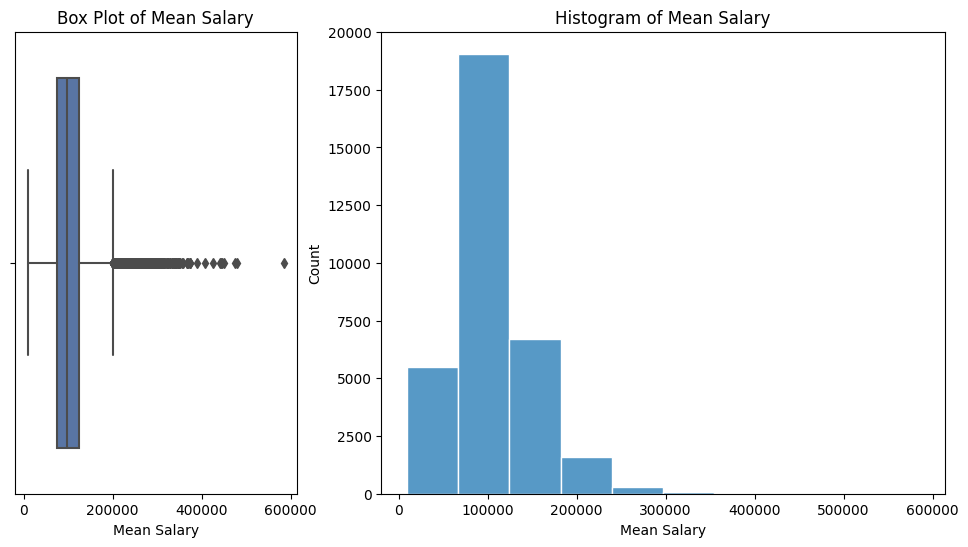

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

df_pd = df.toPandas()
fig, (ax_box, ax_hist) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={"width_ratios": [1, 2]})
sns.set(style="whitegrid")
sns.boxplot(x=df_pd["Mean_Salary"], ax=ax_box)
ax_box.set_title("Box Plot of Mean Salary")
ax_box.set_xlabel("Mean Salary")
sns.histplot(df_pd["Mean_Salary"], bins=10, kde=False, ax=ax_hist)
ax_hist.set_title("Histogram of Mean Salary")
ax_hist.set_xlabel("Mean Salary")
plt.show()

There is a big range of mean salary values. The mean is 104938.65200372947. Min value is 9200, and max is 585000. Since the distribution of the Mean Salary follows a normal distribution, no other transformation would be needed. There are outliers greater than 300k however since these data would represent the population, we will not remove them.

In [ ]:
#Check for the salary outliers that are greater than 300k
df_salary_outlier = df.filter((col("Mean_Salary") > 300000))
df_salary_outlier.orderBy(col("Mean_Salary").desc()).show()
df_salary_outlier.count()

+--------------------+--------------------+--------------------+-------+------+--------------------+--------------------+-------------+-----+----------------+-----------+--------------------+--------------------+--------------------+-------+--------+-------------+-------+--------------------+--------------+--------------------+
|                  ID|                 Job|          Jobs_Group|Profile|Remote|             Company|            Location|         City|State|Frecuency_Salary|Mean_Salary|              Skills|              Sector|        Sector_Group|Revenue|Employee|Company_Score|Reviews|            Director|Director_Score|                 URL|
+--------------------+--------------------+--------------------+-------+------+--------------------+--------------------+-------------+-----+----------------+-----------+--------------------+--------------------+--------------------+-------+--------+-------------+-------+--------------------+--------------+--------------------+
|job_21060

78

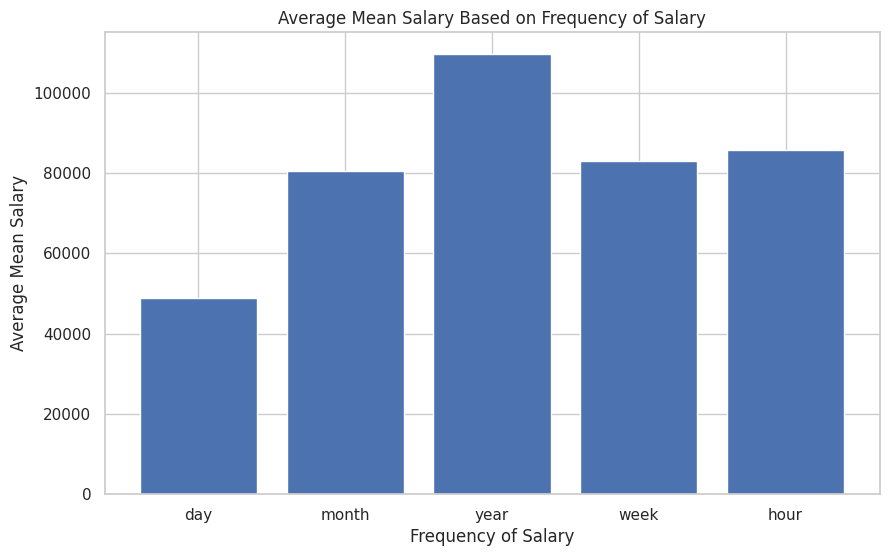

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Group by the frequency column and calculate the average mean salary
average_salary_df = df.groupBy("Frecuency_Salary").avg("Mean_Salary").toPandas()
plt.figure(figsize=(10, 6))
plt.bar(average_salary_df["Frecuency_Salary"], average_salary_df["avg(Mean_Salary)"])
plt.xlabel("Frequency of Salary")
plt.ylabel("Average Mean Salary")
plt.title("Average Mean Salary Based on Frequency of Salary")
plt.show()


Frequency salary has "year", "day" and "hour" however the Mean_salary column is still in annual salary. Based on the graph above, there appears to be correlation between the Mean Salary and the Classifcation of frequency of Salary, so we will use this a feature.



# EDA - Skills column

In [ ]:
## EDA on Skills column - Sarah

from pyspark.sql.functions import udf, explode, col
from pyspark.sql.types import ArrayType, StringType

skills_column = "Skills"

#Check for any null skills
df_null = df.filter((col("Skills").isNull()) | (col("Skills") == "NULL"))

# Show the rows with null values in the "Skills" column
df_null.show()

# Define a UDF to extract words from the string representation of the list
@udf(ArrayType(StringType()))
def extract_words(skills_string):
    # Remove brackets and quotes, then split by ', ' to get an array of words
    return [word.strip(" '") for word in skills_string[1:-1].split(", ")]

df_array = df.withColumn("skills_array", extract_words(col(skills_column)))

df_array.show()

df_exploded = df_array.select(explode(col("skills_array")).alias("word"))

distinct_words = df_exploded.select("word").distinct().collect()


distinct_words_list = [row["word"] for row in distinct_words]

duplicates = set(word for word in distinct_words_list if distinct_words_list.count(word) > 1)

if duplicates:
    print("Duplicate values in distinct_words_list:", duplicates)
else:
    print("No duplicates found in distinct_words_list.")


print(distinct_words_list)
print("Total number of distinct words:", len(distinct_words_list))



+---+---+----------+-------+------+-------+--------+----+-----+----------------+-----------+------+------+------------+-------+--------+-------------+-------+--------+--------------+---+
| ID|Job|Jobs_Group|Profile|Remote|Company|Location|City|State|Frecuency_Salary|Mean_Salary|Skills|Sector|Sector_Group|Revenue|Employee|Company_Score|Reviews|Director|Director_Score|URL|
+---+---+----------+-------+------+-------+--------+----+-----+----------------+-----------+------+------+------------+-------+--------+-------------+-------+--------+--------------+---+
+---+---+----------+-------+------+-------+--------+----+-----+----------------+-----------+------+------+------------+-------+--------+-------------+-------+--------+--------------+---+

+--------------------+--------------------+--------------------+-------+------+--------------------+--------------------+---------------+-----+----------------+-----------------+--------------------+--------------------+--------------------+-------+--

In [ ]:
# Count the occurrences of each word
word_counts = df_exploded.groupBy("word").count()
word_counts.orderBy("count", ascending=False).show(100, truncate=False)


+-----------------------+-----+
|word                   |count|
+-----------------------+-----+
|Bachelor               |21302|
|Office                 |13076|
|Excel                  |9208 |
|SQL                    |8809 |
|Master                 |6030 |
|Python                 |5914 |
|CPA                    |4516 |
|PowerPoint             |3992 |
|Tableau                |3830 |
|Power BI               |3449 |
|Word                   |3305 |
|Access                 |2595 |
|ERP                    |2409 |
|Agile                  |2369 |
|AWS                    |2322 |
|R                      |2191 |
|Azure                  |1947 |
|SAP                    |1899 |
|Artificial Intelligence|1821 |
|Oracle                 |1817 |
|MBA                    |1702 |
|English                |1675 |
|                       |1555 |
|Spark                  |1520 |
|Machine Learning       |1518 |
|Java                   |1200 |
|Salesforce             |1036 |
|Snowflake              |994  |
|PhD    

In [ ]:
df = df_array
df.show()

+--------------------+--------------------+--------------------+-------+------+--------------------+--------------------+---------------+-----+----------------+-----------------+--------------------+--------------------+--------------------+-------+--------+-------------+-------+--------------------+--------------+--------------------+--------------------+
|                  ID|                 Job|          Jobs_Group|Profile|Remote|             Company|            Location|           City|State|Frecuency_Salary|      Mean_Salary|              Skills|              Sector|        Sector_Group|Revenue|Employee|Company_Score|Reviews|            Director|Director_Score|                 URL|        skills_array|
+--------------------+--------------------+--------------------+-------+------+--------------------+--------------------+---------------+-----+----------------+-----------------+--------------------+--------------------+--------------------+-------+--------+-------------+-------+--

In [ ]:
display(df)

DataFrame[ID: string, Job: string, Jobs_Group: string, Profile: string, Remote: string, Company: string, Location: string, City: string, State: string, Frecuency_Salary: string, Mean_Salary: double, Skills: string, Sector: string, Sector_Group: string, Revenue: string, Employee: string, Company_Score: double, Reviews: double, Director: string, Director_Score: double, URL: string, skills_array: array<string>]

In [ ]:
from pyspark.ml.feature import HashingTF

hashingTF = HashingTF(inputCol="skills_array", outputCol="Feature_skills", numFeatures=98)
df_transformed = hashingTF.transform(df)
df_transformed.show()
df_skills = df_transformed.select("ID", "Mean_Salary", "Feature_skills")
df_skills.show(truncate=False)

df = df_transformed


+--------------------+--------------------+--------------------+-------+------+--------------------+--------------------+---------------+-----+----------------+-----------------+--------------------+--------------------+--------------------+-------+--------+-------------+-------+--------------------+--------------+--------------------+--------------------+--------------------+
|                  ID|                 Job|          Jobs_Group|Profile|Remote|             Company|            Location|           City|State|Frecuency_Salary|      Mean_Salary|              Skills|              Sector|        Sector_Group|Revenue|Employee|Company_Score|Reviews|            Director|Director_Score|                 URL|        skills_array|      Feature_skills|
+--------------------+--------------------+--------------------+-------+------+--------------------+--------------------+---------------+-----+----------------+-----------------+--------------------+--------------------+--------------------

# EDA - Revenue, Employee, Profile, Remote, Company Score

In [ ]:
revenue_counts = df.groupBy("Revenue").count()
revenue_counts.show(truncate=False)

+-------+-----+
|Revenue|count|
+-------+-----+
|XL     |2356 |
|XXXL   |4245 |
|M      |1792 |
|L      |949  |
|S      |1289 |
|XS     |1319 |
|NaN    |18309|
|XXS    |868  |
|XXL    |1391 |
|XXXS   |721  |
+-------+-----+



In [ ]:
#Nan values is more in more than half of the dataset, so we should not drop these rows
#I will categorize this as "Other"
from pyspark.sql.functions import when, col, isnan
df = df.withColumn('Revenue', when(isnan(col('Revenue')), 'Other').otherwise(col('Revenue')))
df.show()

+--------------------+--------------------+--------------------+-------+------+--------------------+--------------------+---------------+-----+----------------+-----------------+--------------------+--------------------+--------------------+-------+--------+-------------+-------+--------------------+--------------+--------------------+--------------------+--------------------+
|                  ID|                 Job|          Jobs_Group|Profile|Remote|             Company|            Location|           City|State|Frecuency_Salary|      Mean_Salary|              Skills|              Sector|        Sector_Group|Revenue|Employee|Company_Score|Reviews|            Director|Director_Score|                 URL|        skills_array|      Feature_skills|
+--------------------+--------------------+--------------------+-------+------+--------------------+--------------------+---------------+-----+----------------+-----------------+--------------------+--------------------+--------------------

In [ ]:
#check if we can derive this based on the number of employees
employee_counts = df.groupBy("Employee").count()
employee_counts.show(truncate=False)

+--------+-----+
|Employee|count|
+--------+-----+
|XL      |3380 |
|XXXL    |7976 |
|M       |1507 |
|L       |1289 |
|XS      |1733 |
|S       |2080 |
|NaN     |12790|
|XXS     |5    |
|XXL     |1824 |
|XXXS    |655  |
+--------+-----+



In [ ]:
#do the same, replace the nan values with Other
df = df.withColumn('Employee', when(isnan(col('Employee')), 'Other').otherwise(col('Employee')))
df.show()

+--------------------+--------------------+--------------------+-------+------+--------------------+--------------------+---------------+-----+----------------+-----------------+--------------------+--------------------+--------------------+-------+--------+-------------+-------+--------------------+--------------+--------------------+--------------------+--------------------+
|                  ID|                 Job|          Jobs_Group|Profile|Remote|             Company|            Location|           City|State|Frecuency_Salary|      Mean_Salary|              Skills|              Sector|        Sector_Group|Revenue|Employee|Company_Score|Reviews|            Director|Director_Score|                 URL|        skills_array|      Feature_skills|
+--------------------+--------------------+--------------------+-------+------+--------------------+--------------------+---------------+-----+----------------+-----------------+--------------------+--------------------+--------------------

In [ ]:
#clean Nan from Profile
(df.groupBy("Profile").count()).show(truncate=False)
df = df.withColumn('Profile', when(isnan(col('Profile')), 'Standard').otherwise(col('Profile')))
df.show()

+-------+-----+
|Profile|count|
+-------+-----+
|Senior |6020 |
|Lead   |5760 |
|NaN    |21100|
|Junior |359  |
+-------+-----+

+--------------------+--------------------+--------------------+--------+------+--------------------+--------------------+---------------+-----+----------------+-----------------+--------------------+--------------------+--------------------+-------+--------+-------------+-------+--------------------+--------------+--------------------+--------------------+--------------------+
|                  ID|                 Job|          Jobs_Group| Profile|Remote|             Company|            Location|           City|State|Frecuency_Salary|      Mean_Salary|              Skills|              Sector|        Sector_Group|Revenue|Employee|Company_Score|Reviews|            Director|Director_Score|                 URL|        skills_array|      Feature_skills|
+--------------------+--------------------+--------------------+--------+------+--------------------+--------

In [ ]:
#clean nan for Remote
(df.groupBy("Remote").count()).show(truncate=False)
df = df.withColumn('Remote', when(isnan(col('Remote')), 'Office').otherwise(col('Remote')))
df.show()

+------+-----+
|Remote|count|
+------+-----+
|Remote|10576|
|Hybrid|3350 |
|NaN   |19313|
+------+-----+

+--------------------+--------------------+--------------------+--------+------+--------------------+--------------------+---------------+-----+----------------+-----------------+--------------------+--------------------+--------------------+-------+--------+-------------+-------+--------------------+--------------+--------------------+--------------------+--------------------+
|                  ID|                 Job|          Jobs_Group| Profile|Remote|             Company|            Location|           City|State|Frecuency_Salary|      Mean_Salary|              Skills|              Sector|        Sector_Group|Revenue|Employee|Company_Score|Reviews|            Director|Director_Score|                 URL|        skills_array|      Feature_skills|
+--------------------+--------------------+--------------------+--------+------+--------------------+--------------------+----------

In [ ]:
## Company score with empty values will be set to 0
(df.groupBy("Company_Score").count()).show(truncate=False)
df = df.withColumn('Company_Score', when(isnan(col('Company_Score')), 0).otherwise(col('Company_Score')))
df.show()

+-------------+-----+
|Company_Score|count|
+-------------+-----+
|2.4          |64   |
|3.5          |1728 |
|NaN          |8753 |
|2.9          |288  |
|3.7          |2002 |
|4.5          |287  |
|1.7          |7    |
|2.3          |113  |
|3.4          |1366 |
|4.9          |19   |
|2.5          |174  |
|1.0          |304  |
|3.1          |610  |
|2.7          |242  |
|4.1          |1378 |
|2.2          |45   |
|2.8          |408  |
|4.0          |1859 |
|1.9          |10   |
|3.9          |2124 |
+-------------+-----+
only showing top 20 rows

+--------------------+--------------------+--------------------+--------+------+--------------------+--------------------+---------------+-----+----------------+-----------------+--------------------+--------------------+--------------------+-------+--------+-------------+-------+--------------------+--------------+--------------------+--------------------+--------------------+
|                  ID|                 Job|          Jobs_Group| 

Logically, number of reviews, the name of directors or director score, as well as URL should not affect the salary.

In [ ]:
#There are 3312 nan values in state, which is 10% of the dataset.
# there are some where Location is remote or the working type is Remote, in those instances, we will input state as RM (Remote)
df = df.withColumn("State", when(isnan(col('State')) & ((col("Remote") == "Remote") | col("Location").rlike("Remote")), "RM")
    .otherwise(col("State")))
#there are some where Location is United States, in those instances, we will input state as OT (Other)
df = df.withColumn("State", when(isnan(col('State')) & ((isnan(col("Location")) | col("Location").rlike("United States"))), "OT")
    .otherwise(col("State")))
df.show()
(df.groupBy("State").count()).show(100, truncate=False)

+--------------------+--------------------+--------------------+--------+------+--------------------+--------------------+---------------+-----+----------------+-----------------+--------------------+--------------------+--------------------+-------+--------+-------------+-------+--------------------+--------------+--------------------+--------------------+--------------------+
|                  ID|                 Job|          Jobs_Group| Profile|Remote|             Company|            Location|           City|State|Frecuency_Salary|      Mean_Salary|              Skills|              Sector|        Sector_Group|Revenue|Employee|Company_Score|Reviews|            Director|Director_Score|                 URL|        skills_array|      Feature_skills|
+--------------------+--------------------+--------------------+--------+------+--------------------+--------------------+---------------+-----+----------------+-----------------+--------------------+--------------------+-----------------

In [ ]:
from pyspark.sql.functions import col
df_null_state = df.filter(isnan(col("State")))
df_null_state.show()
# confirming that there are no more null states since we will be using the state as a feature

+---+---+----------+-------+------+-------+--------+----+-----+----------------+-----------+------+------+------------+-------+--------+-------------+-------+--------+--------------+---+------------+--------------+
| ID|Job|Jobs_Group|Profile|Remote|Company|Location|City|State|Frecuency_Salary|Mean_Salary|Skills|Sector|Sector_Group|Revenue|Employee|Company_Score|Reviews|Director|Director_Score|URL|skills_array|Feature_skills|
+---+---+----------+-------+------+-------+--------+----+-----+----------------+-----------+------+------+------------+-------+--------+-------------+-------+--------+--------------+---+------------+--------------+
+---+---+----------+-------+------+-------+--------+----+-----+----------------+-----------+------+------+------------+-------+--------+-------------+-------+--------+--------------+---+------------+--------------+



In [ ]:
# Renaming Columns

df = df.withColumnRenamed("Frecuency_Salary", "Sal_Freq")\
      .withColumnRenamed("Remote", "Work_Argmnt")

### Create a new engineered feature called Pay_Zone

In [ ]:
df = df.withColumn('Pay_Zone', when((col("State") == 'CA') | (col("State") == 'WA') | (col("State") == 'NY') | (col("State") == 'MA') | (col("State") == 'DC'), "Zone A")\
    .when((col("State") == 'TX') | (col("State") == 'IL') | (col("State") == 'CO') | (col("State") == 'NJ') | (col("State") == 'OR') | (col("State") == 'CT') | (col("State") == 'DE') | (col("State") == 'PA') | (col("State") == 'RI')  | (col("State") == 'GA') | (col("State") == 'HI'),  "Zone B")\
    .when((col("State") == 'RM') , "Zone RM")\
    .otherwise("Zone C")
)
df.show()

+--------------------+--------------------+--------------------+--------+-----------+--------------------+--------------------+---------------+-----+--------+-----------------+--------------------+--------------------+--------------------+-------+--------+-------------+-------+--------------------+--------------+--------------------+--------------------+--------------------+--------+
|                  ID|                 Job|          Jobs_Group| Profile|Work_Argmnt|             Company|            Location|           City|State|Sal_Freq|      Mean_Salary|              Skills|              Sector|        Sector_Group|Revenue|Employee|Company_Score|Reviews|            Director|Director_Score|                 URL|        skills_array|      Feature_skills|Pay_Zone|
+--------------------+--------------------+--------------------+--------+-----------+--------------------+--------------------+---------------+-----+--------+-----------------+--------------------+--------------------+--------

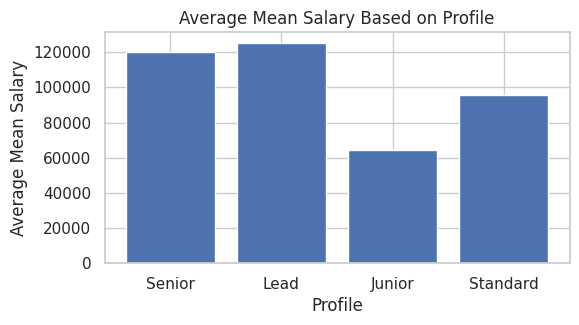

In [ ]:
# Average Salary grouped by Profile

average_salary_df = df.groupBy("Profile").avg("Mean_Salary").toPandas()
plt.figure(figsize=(6, 3))
plt.bar(average_salary_df["Profile"], average_salary_df["avg(Mean_Salary)"])
plt.xlabel("Profile")
plt.ylabel("Average Mean Salary")
plt.title("Average Mean Salary Based on Profile")
plt.show()

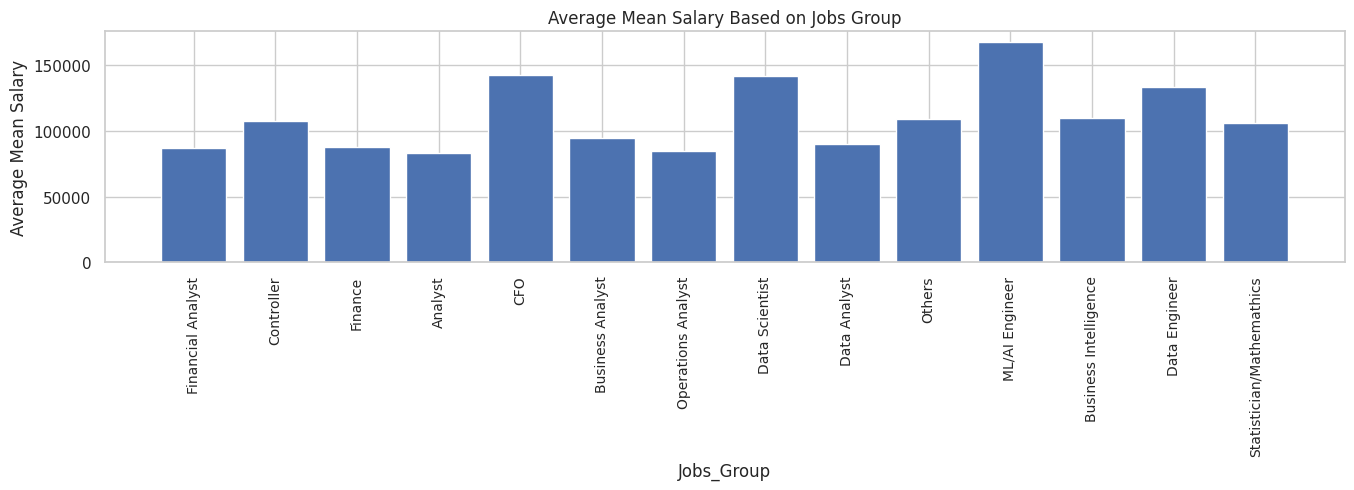

In [ ]:
# Average Salary grouped by Jobs Group

average_salary_df = df.groupBy("Jobs_Group").avg("Mean_Salary").toPandas()
plt.figure(figsize=(16, 3))
plt.bar(average_salary_df["Jobs_Group"], average_salary_df["avg(Mean_Salary)"])
plt.xlabel("Jobs_Group")
plt.xticks(fontsize=10,rotation = 90)
plt.ylabel("Average Mean Salary")
plt.title("Average Mean Salary Based on Jobs Group")
plt.show()


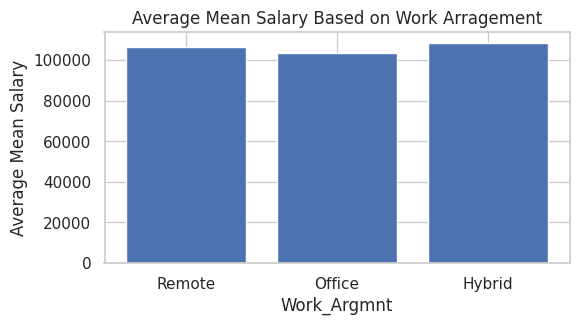

In [ ]:
# Average Salary grouped by Work Arrangement

average_salary_df = df.groupBy("Work_Argmnt").avg("Mean_Salary").toPandas()
plt.figure(figsize=(6, 3))
plt.bar(average_salary_df["Work_Argmnt"], average_salary_df["avg(Mean_Salary)"])
plt.xlabel("Work_Argmnt")
plt.ylabel("Average Mean Salary")
plt.title("Average Mean Salary Based on Work Arragement")
plt.show()

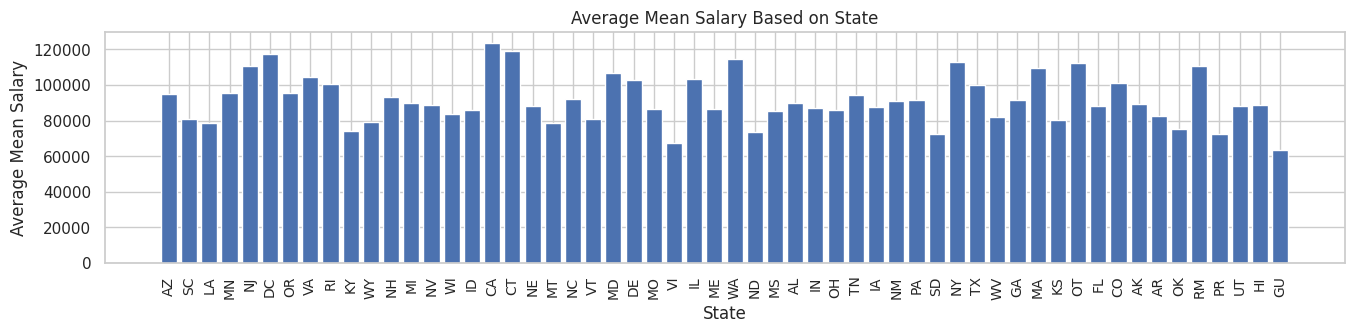

In [ ]:
# Average Salary grouped by State

average_salary_df = df.groupBy("State").avg("Mean_Salary").toPandas()
plt.figure(figsize=(16, 3))
plt.bar(average_salary_df["State"], average_salary_df["avg(Mean_Salary)"])
plt.xlabel("State")
plt.xticks(fontsize=10,rotation = 90)
plt.ylabel("Average Mean Salary")
plt.title("Average Mean Salary Based on State")
plt.show()

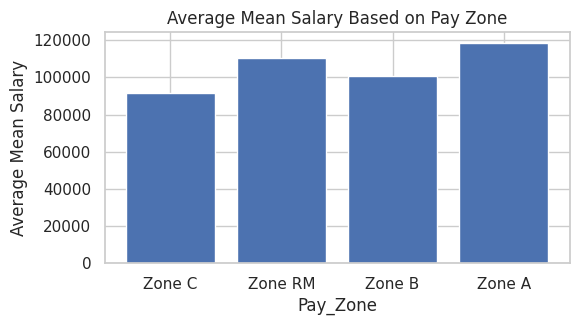

In [ ]:
# Average Salary grouped by Pay Zone

average_salary_df = df.groupBy("Pay_Zone").avg("Mean_Salary").toPandas()
plt.figure(figsize=(6, 3))
plt.bar(average_salary_df["Pay_Zone"], average_salary_df["avg(Mean_Salary)"])
plt.xlabel("Pay_Zone")
plt.ylabel("Average Mean Salary")
plt.title("Average Mean Salary Based on Pay Zone")
plt.show()

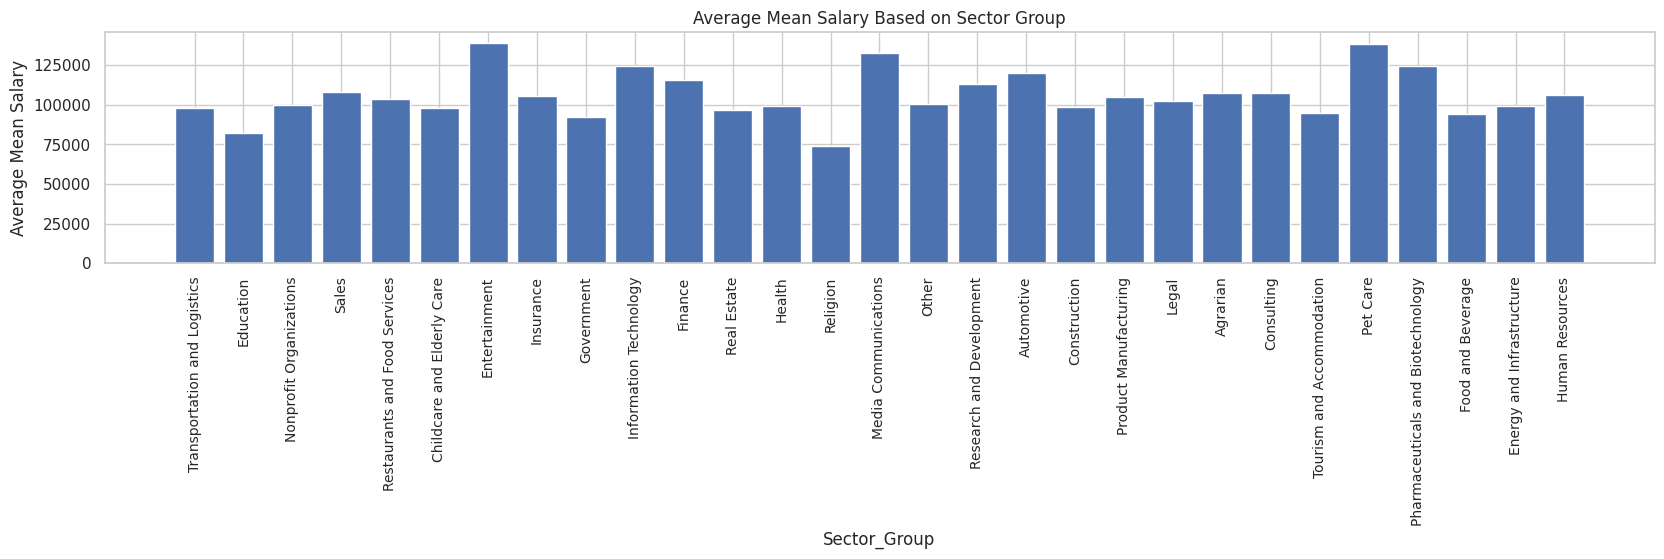

In [ ]:
# Average Salary grouped by Sector Group

average_salary_df = df.groupBy("Sector_Group").avg("Mean_Salary").toPandas()
plt.figure(figsize=(20, 3))
plt.bar(average_salary_df["Sector_Group"], average_salary_df["avg(Mean_Salary)"])
plt.xlabel("Sector_Group")
plt.xticks(fontsize=10,rotation = 90)
plt.ylabel("Average Mean Salary")
plt.title("Average Mean Salary Based on Sector Group")
plt.show()

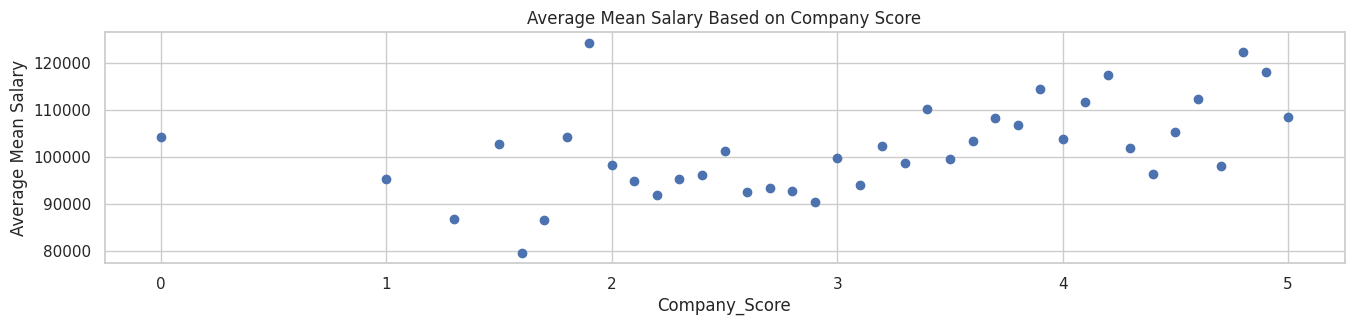

In [ ]:
# Average Salary grouped by Company Score

average_salary_df = df.groupBy("Company_Score").avg("Mean_Salary").toPandas()
plt.figure(figsize=(16, 3))
plt.scatter(average_salary_df["Company_Score"], average_salary_df["avg(Mean_Salary)"])
plt.xlabel("Company_Score")
plt.ylabel("Average Mean Salary")
plt.title("Average Mean Salary Based on Company Score")
plt.show()

 The scatter plot shows a strong correlation of company score with mean salary. Higher the mean salary, greater the company score

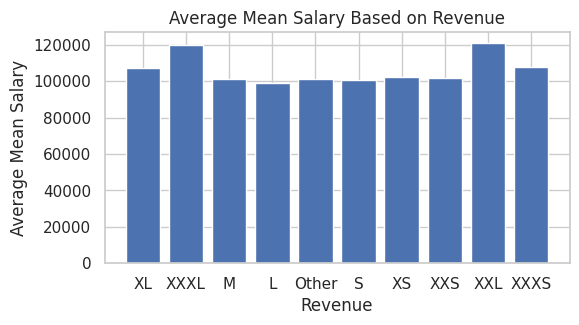

In [ ]:
# Average Salary grouped by Revenue

average_salary_df = df.groupBy("Revenue").avg("Mean_Salary").toPandas()
plt.figure(figsize=(6, 3))
plt.bar(average_salary_df["Revenue"], average_salary_df["avg(Mean_Salary)"])
plt.xlabel("Revenue")
plt.ylabel("Average Mean Salary")
plt.title("Average Mean Salary Based on Revenue")
plt.show()

Companies that are XL or above in average offer better mean salaries

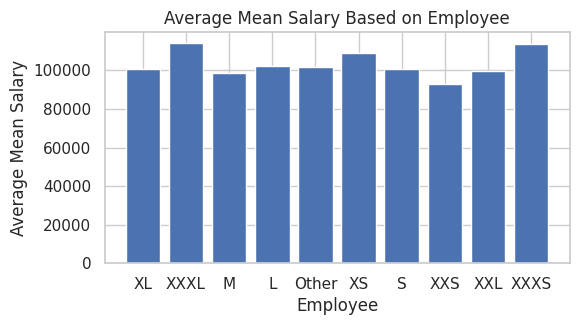

In [ ]:
# Average Salary grouped by Employee

average_salary_df = df.groupBy("Employee").avg("Mean_Salary").toPandas()
plt.figure(figsize=(6, 3))
plt.bar(average_salary_df["Employee"], average_salary_df["avg(Mean_Salary)"])
plt.xlabel("Employee")
plt.ylabel("Average Mean Salary")
plt.title("Average Mean Salary Based on Employee")
plt.show()

Phik (𝜙k) is a new and practical correlation coefficient that works consistently between categorical, ordinal and interval variables, captures non-linear dependency and reverts to the Pearson correlation coefficient in case of a bivariate normal input distribution.

In [ ]:
%%capture
# install phik (if not installed yet)
import sys

!"{sys.executable}" -m pip install phik

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

import phik
from phik.report import plot_correlation_matrix
from phik import report


df_copy_phik = df.select("Jobs_Group", "Profile", "Work_Argmnt","Mean_Salary", "Sector_Group", "Company_Score", "Revenue", "Employee" , "State", "Sal_Freq", "Pay_Zone").toPandas()
phik_overview = df_copy_phik.phik_matrix()
phik_overview.round(2)



interval columns not set, guessing: ['Mean_Salary', 'Company_Score']


,Jobs_Group,Profile,Work_Argmnt,Mean_Salary,Sector_Group,Company_Score,Revenue,Employee,State,Sal_Freq,Pay_Zone
Jobs_Group,1.00,0.61,0.25,0.40,0.39,0.16,0.21,0.22,0.29,0.21,0.20
Profile,0.61,1.00,0.08,0.30,0.23,0.08,0.15,0.14,0.19,0.13,0.15
Work_Argmnt,0.25,0.08,1.00,0.10,0.30,0.14,0.15,0.13,0.57,0.05,0.34
Mean_Salary,0.40,0.30,0.10,1.00,0.26,0.06,0.18,0.14,0.29,0.32,0.23
Sector_Group,0.39,0.23,0.30,0.26,1.00,0.55,0.54,0.54,0.44,0.35,0.26
Company_Score,0.16,0.08,0.14,0.06,0.55,1.00,0.41,0.50,0.25,0.13,0.11
Revenue,0.21,0.15,0.15,0.18,0.54,0.41,1.00,0.86,0.28,0.21,0.13
Employee,0.22,0.14,0.13,0.14,0.54,0.50,0.86,1.00,0.26,0.19,0.13
State,0.29,0.19,0.57,0.29,0.44,0.25,0.28,0.26,1.00,0.30,1.00
Sal_Freq,0.21,0.13,0.05,0.32,0.35,0.13,0.21,0.19,0.30,1.00,0.10


Since the feature "State" is better correlated with Mean_Salary than Payzone, we decided to drop Pay_Zone from the feature list, in favor of the State feature.

*   State vs Mean_Salary Correlation: 0.29
*   Pay_Zone vs Mean_Salary Correlation: 0.23

In [ ]:
df_copy_phik = df.select("Jobs_Group", "Profile", "Work_Argmnt","Mean_Salary", "Sector_Group", "Company_Score", "Revenue", "Employee" , "State", "Sal_Freq").toPandas()
phik_overview = df_copy_phik.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['Mean_Salary', 'Company_Score']


,Jobs_Group,Profile,Work_Argmnt,Mean_Salary,Sector_Group,Company_Score,Revenue,Employee,State,Sal_Freq
Jobs_Group,1.00,0.61,0.25,0.40,0.39,0.16,0.21,0.22,0.29,0.21
Profile,0.61,1.00,0.08,0.30,0.23,0.08,0.15,0.14,0.19,0.13
Work_Argmnt,0.25,0.08,1.00,0.10,0.30,0.14,0.15,0.13,0.57,0.05
Mean_Salary,0.40,0.30,0.10,1.00,0.26,0.06,0.18,0.14,0.29,0.32
Sector_Group,0.39,0.23,0.30,0.26,1.00,0.55,0.54,0.54,0.44,0.35
Company_Score,0.16,0.08,0.14,0.06,0.55,1.00,0.41,0.50,0.25,0.13
Revenue,0.21,0.15,0.15,0.18,0.54,0.41,1.00,0.86,0.28,0.21
Employee,0.22,0.14,0.13,0.14,0.54,0.50,0.86,1.00,0.26,0.19
State,0.29,0.19,0.57,0.29,0.44,0.25,0.28,0.26,1.00,0.30
Sal_Freq,0.21,0.13,0.05,0.32,0.35,0.13,0.21,0.19,0.30,1.00


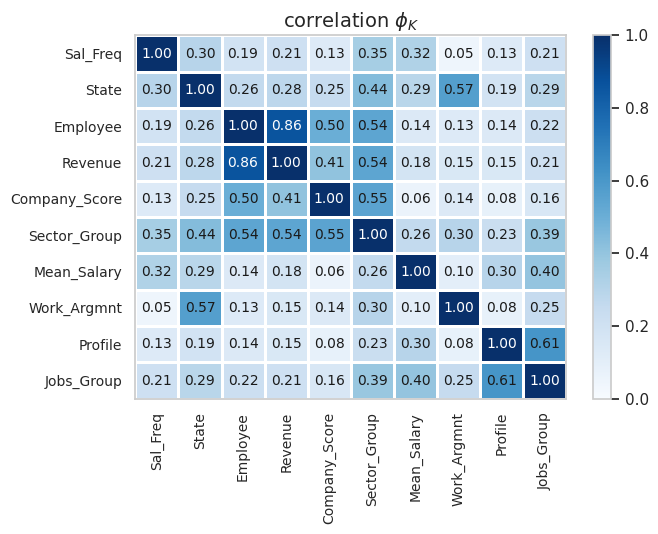

In [ ]:
plot_correlation_matrix(phik_overview.values.round(2), x_labels=phik_overview.columns, y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1,
                        figsize=(7,5.5))
plt.tight_layout()

interval columns not set, guessing: ['Mean_Salary', 'Company_Score']


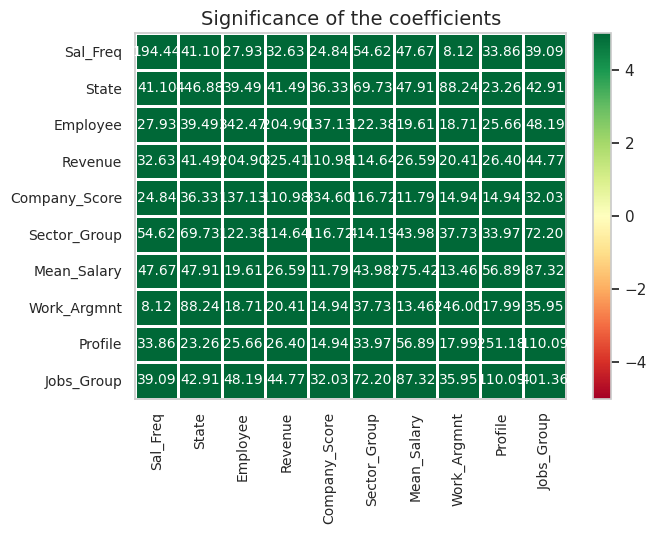

In [ ]:
significance_overview = df_copy_phik.significance_matrix()
plot_correlation_matrix(significance_overview.fillna(0).values,
                        x_labels=significance_overview.columns,
                        y_labels=significance_overview.index,
                        vmin=-5, vmax=5, title="Significance of the coefficients",
                        usetex=False, fontsize_factor=1, figsize=(7, 5.5))
plt.tight_layout()

In [ ]:
df_copy_phik_skills = df.select("Mean_Salary", "skills").toPandas()
phik_overview_skills = df_copy_phik_skills.phik_matrix()
phik_overview_skills.round(2)

interval columns not set, guessing: ['Mean_Salary']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable skills is large: 10801. Are you sure this is not an interval variable? Analysis for pairs of variables including skills can be slow.
  warnings.warn(


,Mean_Salary,skills
Mean_Salary,1.0,0.0
skills,0.0,1.0


# Setup Preprocessing Pipeline

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, Imputer, VectorAssembler

In [ ]:
df = df ["Jobs_Group", "Profile", "Work_Argmnt","State","Feature_skills", "Sector_Group", "Company_Score", "Revenue", "Employee", "Mean_Salary", "Sal_Freq"]
df.show()

+--------------------+--------+-----------+-----+--------------------+--------------------+-------------+-------+--------+-----------------+--------+
|          Jobs_Group| Profile|Work_Argmnt|State|      Feature_skills|        Sector_Group|Company_Score|Revenue|Employee|      Mean_Salary|Sal_Freq|
+--------------------+--------+-----------+-----+--------------------+--------------------+-------------+-------+--------+-----------------+--------+
|   Financial Analyst|Standard|     Remote|   RM|(98,[30,74],[1.0,...|Nonprofit Organiz...|          4.2|  Other|      XS|         115000.0|    hour|
|          Controller|Standard|     Office|   NY|(98,[27,30,33,42,...|Nonprofit Organiz...|          3.5|  Other|       M|         185000.0|    year|
|   Financial Analyst|  Senior|     Office|   OT|(98,[30,97],[1.0,...|               Sales|          3.4|   XXXS|    XXXS|          84500.0|    year|
|Business Intellig...|  Senior|     Hybrid|   VA|(98,[30,68,73,75,...|             Finance|         

In [ ]:
indexer = StringIndexer(inputCols=["Jobs_Group", "Profile","Work_Argmnt", "State", "Sal_Freq", "Sector_Group","Revenue", "Employee"], outputCols=["Jobs_Grp_indexed", "Prfle_indexed", "Work_Arg_indexed","State_indexed", "Sal_Freq_indexed", "Sector_Grp_indexed", "Rev_indexed", "Emp_indexed"])

In [ ]:
df_r = indexer.fit(df).transform(df)
df_r.show()

+--------------------+--------+-----------+-----+--------------------+--------------------+-------------+-------+--------+-----------------+--------+----------------+-------------+----------------+-------------+----------------+------------------+-----------+-----------+
|          Jobs_Group| Profile|Work_Argmnt|State|      Feature_skills|        Sector_Group|Company_Score|Revenue|Employee|      Mean_Salary|Sal_Freq|Jobs_Grp_indexed|Prfle_indexed|Work_Arg_indexed|State_indexed|Sal_Freq_indexed|Sector_Grp_indexed|Rev_indexed|Emp_indexed|
+--------------------+--------+-----------+-----+--------------------+--------------------+-------------+-------+--------+-----------------+--------+----------------+-------------+----------------+-------------+----------------+------------------+-----------+-----------+
|   Financial Analyst|Standard|     Remote|   RM|(98,[30,74],[1.0,...|Nonprofit Organiz...|          4.2|  Other|      XS|         115000.0|    hour|             0.0|          0.0|    

In [ ]:
df_r.columns

['Jobs_Group',
 'Profile',
 'Work_Argmnt',
 'State',
 'Feature_skills',
 'Sector_Group',
 'Company_Score',
 'Revenue',
 'Employee',
 'Mean_Salary',
 'Sal_Freq',
 'Jobs_Grp_indexed',
 'Prfle_indexed',
 'Work_Arg_indexed',
 'State_indexed',
 'Sal_Freq_indexed',
 'Sector_Grp_indexed',
 'Rev_indexed',
 'Emp_indexed']

In [ ]:
assembler = VectorAssembler(inputCols=['Jobs_Grp_indexed','Prfle_indexed', 'Work_Arg_indexed', 'State_indexed', 'Sal_Freq_indexed', 'Feature_skills', 'Sector_Grp_indexed', 'Company_Score', 'Rev_indexed', 'Emp_indexed'], outputCol ="Ind_Feat")
transformed = assembler.transform(df_r)

In [ ]:
from pyspark.ml.feature import MinMaxScaler, StandardScaler
scaler = StandardScaler(inputCol="Ind_Feat", outputCol = "scaled_Ind_Feat")

In [ ]:
scalerModel =  scaler.fit(transformed.select("Ind_Feat"))
scaledData = scalerModel.transform(transformed)

In [ ]:
scaledData.select('scaled_Ind_Feat').show()

+--------------------+
|     scaled_Ind_Feat|
+--------------------+
|(107,[2,3,4,35,79...|
|(107,[0,3,32,35,3...|
|(107,[1,3,35,102,...|
|(107,[0,1,2,3,35,...|
|(107,[0,2,4,80,10...|
|(107,[1,2,35,52,7...|
|(107,[0,2,3,4,35,...|
|(107,[0,1,2,3,4,7...|
|(107,[3,47,52,80,...|
|(107,[0,2,3,35,45...|
|(107,[0,2,79,103]...|
|(107,[0,3,4,38,43...|
|(107,[3,35,80,96,...|
|(107,[0,3,35,83,1...|
|(107,[0,1,3,33,35...|
|(107,[0,35,52,73,...|
|(107,[0,1,3,4,80]...|
|(107,[0,3,4,45,10...|
|(107,[0,3,35,43,1...|
|(107,[3,35,45],[0...|
+--------------------+
only showing top 20 rows



In [ ]:
scaledData.show()

+--------------------+--------+-----------+-----+--------------------+--------------------+-------------+-------+--------+-----------------+--------+----------------+-------------+----------------+-------------+----------------+------------------+-----------+-----------+--------------------+--------------------+
|          Jobs_Group| Profile|Work_Argmnt|State|      Feature_skills|        Sector_Group|Company_Score|Revenue|Employee|      Mean_Salary|Sal_Freq|Jobs_Grp_indexed|Prfle_indexed|Work_Arg_indexed|State_indexed|Sal_Freq_indexed|Sector_Grp_indexed|Rev_indexed|Emp_indexed|            Ind_Feat|     scaled_Ind_Feat|
+--------------------+--------+-----------+-----+--------------------+--------------------+-------------+-------+--------+-----------------+--------+----------------+-------------+----------------+-------------+----------------+------------------+-----------+-----------+--------------------+--------------------+
|   Financial Analyst|Standard|     Remote|   RM|(98,[30,7

In [ ]:
fnl_data = scaledData.select("scaled_Ind_Feat", "Mean_Salary")

In [ ]:
fnl_data.show()

+--------------------+-----------------+
|     scaled_Ind_Feat|      Mean_Salary|
+--------------------+-----------------+
|(107,[2,3,4,35,79...|         115000.0|
|(107,[0,3,32,35,3...|         185000.0|
|(107,[1,3,35,102,...|          84500.0|
|(107,[0,1,2,3,35,...|         111625.0|
|(107,[0,2,4,80,10...|         102690.4|
|(107,[1,2,35,52,7...|         124650.0|
|(107,[0,2,3,4,35,...|          92000.0|
|(107,[0,1,2,3,4,7...|         115000.0|
|(107,[3,47,52,80,...|         106870.0|
|(107,[0,2,3,35,45...|          78500.5|
|(107,[0,2,79,103]...|          89127.5|
|(107,[0,3,4,38,43...|80748.40000000001|
|(107,[3,35,80,96,...|          68878.5|
|(107,[0,3,35,83,1...|         135900.0|
|(107,[0,1,3,33,35...|          93050.0|
|(107,[0,35,52,73,...|          80850.0|
|(107,[0,1,3,4,80]...|          36800.0|
|(107,[0,3,4,45,10...|          88172.8|
|(107,[0,3,35,43,1...|         120000.0|
|(107,[3,35,45],[0...|         119072.5|
+--------------------+-----------------+
only showing top

# ML Model #

## Train Test Split ##

In [ ]:
# Splitting data into Train and Test sets

train, test = fnl_data.randomSplit([0.80, 0.20])

## Applying Linear Regression ##

In [ ]:
from pyspark.ml.regression import LinearRegression

lnr_reg = LinearRegression(featuresCol = 'scaled_Ind_Feat', labelCol ='Mean_Salary')
lnr_reg_fit = lnr_reg.fit(train)

In [ ]:
lnr_reg_fit.coefficients

DenseVector([3955.2633, 6876.2094, 537.7819, -6564.0277, -6736.6606, 0.0, 0.0, 0.0, 0.0, 0.0, -350.5161, 0.0, 0.0, 0.0, 63.2528, 0.0, -705.5548, 0.0, 0.0, 0.0, 568.5154, -541.1539, 167.1042, -96.4188, -90.1431, 0.0, 1176.1658, 0.0, -688.6073, 0.0, 0.0, 3578.4453, 258.8073, 503.4176, -549.7842, -1140.6937, 0.0, 0.0, 4679.1253, -265.7283, 0.0, 0.0, 3570.789, -681.1065, 181.0959, -1136.7344, -44.0628, 5970.7237, 0.0, -512.0501, 0.0, 0.0, 1076.4066, -505.7361, 0.0, -155.9488, 86.0116, -115.9705, 0.0, 708.569, 0.0, 0.0, -96.7693, 0.0, 1200.7831, 0.0, -847.4097, 0.0, 36.3211, 812.3465, 260.9228, 0.0, 192.6879, 2354.693, 0.0, 0.0, -300.7703, 0.0, -1482.557, 3274.6388, -2998.7159, 0.0, 0.0, 412.4657, 0.0, 2365.786, 0.0, 2528.1281, -115.3205, 163.8169, -881.8939, -338.8258, -145.5336, 136.4793, 1116.1135, -39.9208, -345.5855, 665.3962, 428.3383, -1455.5813, 0.0, 450.6585, -6093.9799, -32.0416, 685.5483, 773.7253, -997.8753])

In [ ]:
lnr_reg_fit.intercept

100209.62636200292

In [ ]:
# Predicting results
lnr_pred_rslt = lnr_reg_fit.evaluate(test)
lnr_pred_rslt.predictions.show()

+--------------------+-----------+------------------+
|     scaled_Ind_Feat|Mean_Salary|        prediction|
+--------------------+-----------+------------------+
|(107,[0,1,2,3,4,2...|    32200.0|100269.73038613063|
|(107,[0,1,2,3,4,2...|   124200.0| 94801.22344835299|
|(107,[0,1,2,3,4,3...|   115000.0|118006.17474866525|
|(107,[0,1,2,3,4,3...|   119600.0| 134236.3928830143|
|(107,[0,1,2,3,4,3...|    96600.0|131001.42460438517|
|(107,[0,1,2,3,4,3...|   124200.0|120571.19024618203|
|(107,[0,1,2,3,4,3...|   116932.0| 116111.4931365126|
|(107,[0,1,2,3,4,3...|   176640.0|140993.45015501734|
|(107,[0,1,2,3,4,3...|    98000.0|50109.961610388964|
|(107,[0,1,2,3,4,3...|   147200.0|107960.54987132156|
|(107,[0,1,2,3,4,3...|   115000.0|128369.72083733532|
|(107,[0,1,2,3,4,3...|    89828.8|119254.56059183014|
|(107,[0,1,2,3,4,3...|    72965.2|100809.55704138412|
|(107,[0,1,2,3,4,3...|   138000.0|101123.06057563267|
|(107,[0,1,2,3,4,3...|   220800.0|  96907.1574941589|
|(107,[0,1,2,3,4,3...|    17

In [ ]:
# Performance Metrics

print("MSE: ", lnr_pred_rslt.meanSquaredError)
print("MAE: ", lnr_pred_rslt.meanAbsoluteError)
print("RMSE Squared: ", lnr_pred_rslt.rootMeanSquaredError)
print("R Squared: ", lnr_pred_rslt.r2)
print("Explained Variance: ", lnr_pred_rslt.explainedVariance, "\n")


MSE:  1342954359.0003815
MAE:  26942.1329578944
RMSE Squared:  36646.341686454616
R Squared:  0.3057237312927553
Explained Variance:  568239047.3999773 



## Applying Random Forest Regressor

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
# Running RandomForestRegressor with numTrees set to 20 and set maxDepth to 10

rf_reg = (RandomForestRegressor(numTrees = 20, maxDepth = 10)
  .setLabelCol("Mean_Salary")
  .setFeaturesCol("scaled_Ind_Feat"))

In [ ]:
print("Printing out the model Parameters:")
print("-"*60)
print(rf_reg.explainParams())
print("-"*60)

Printing out the model Parameters:
------------------------------------------------------------
bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classificatio

In [ ]:
from pyspark.mllib.evaluation import RegressionMetrics
rf_reg_fit = rf_reg.fit(train)

In [ ]:
# Predicting results
rf_pred_rslt = rf_reg_fit.transform(test)
#rf_pred_rslt.predictions.show()

In [ ]:
# Performance Metrics
rm = RegressionMetrics(rf_pred_rslt.select("prediction", "Mean_Salary").rdd.map(lambda x:  (x[0], x[1])))

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
print("MSE: ", rm.meanSquaredError)
print("MAE: ", rm.meanAbsoluteError)
print("RMSE Squared: ", rm.rootMeanSquaredError)
print("R Squared: ", rm.r2)
print("Explained Variance: ", rm.explainedVariance, "\n")

MSE:  1044664656.240284
MAE:  23501.76184723245
RMSE Squared:  32321.27250341923
R Squared:  0.4599325921063303
Explained Variance:  659048344.2881002 



## Applying Decision Tree Regressor

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
# Decision Tree Regression Model

dtree_reg = (DecisionTreeRegressor(maxDepth = 5, maxBins = 10)
            .setLabelCol("Mean_Salary")
           .setFeaturesCol("scaled_Ind_Feat"))
           # featuresCol='scaled_Ind_Feat', labelCol='Mean_Salary')

In [ ]:
dtree_reg_fit = dtree_reg.fit(train)

In [ ]:
# Predicting results
dtree_pred_rslt = dtree_reg_fit.transform(test)

In [ ]:
# Performance Metrics
dt_rm = RegressionMetrics(dtree_pred_rslt.select("prediction", "Mean_Salary").rdd.map(lambda x:  (x[0], x[1])))

In [ ]:
print("MSE: ", dt_rm.meanSquaredError)
print("MAE: ", dt_rm.meanAbsoluteError)
print("RMSE Squared: ", dt_rm.rootMeanSquaredError)
print("R Squared: ", dt_rm.r2)
print("Explained Variance: ", dt_rm.explainedVariance, "\n")

MSE:  1317326501.343088
MAE:  26560.13798379331
RMSE Squared:  36294.992786100505
R Squared:  0.3189727395483375
Explained Variance:  607456885.2189583 




# Performing Hyperparameter tuning of models

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Parameter grid for hyperparameter tuning
param_grid_linear_reg = ParamGridBuilder() \
    .addGrid(lnr_reg.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(lnr_reg.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

param_grid_random_forest = ParamGridBuilder() \
    .addGrid(rf_reg.numTrees, [10, 20, 30]) \
    .addGrid(rf_reg.maxDepth, [5, 10, 15]) \
    .build()

param_grid_decision_tree = ParamGridBuilder() \
    .addGrid(dtree_reg.maxDepth, [5, 10, 15]) \
    .addGrid(dtree_reg.maxBins, [20, 40, 60]) \
    .build()

# CrossValidator for hyperparameter tuning
crossval_linear_reg = CrossValidator(estimator=lnr_reg,
                                     estimatorParamMaps=param_grid_linear_reg,
                                     evaluator=RegressionEvaluator(labelCol='Mean_Salary'),
                                     numFolds=3)

crossval_random_forest = CrossValidator(estimator=rf_reg,
                                        estimatorParamMaps=param_grid_random_forest,
                                        evaluator=RegressionEvaluator(labelCol='Mean_Salary'),
                                        numFolds=3)

crossval_decision_tree = CrossValidator(estimator=dtree_reg,
                                        estimatorParamMaps=param_grid_decision_tree,
                                        evaluator=RegressionEvaluator(labelCol='Mean_Salary'),
                                        numFolds=3)


# Fit models on the training data for hyperparameter tuning
tuned_linear_reg_model = crossval_linear_reg.fit(train)
tuned_random_forest_model = crossval_random_forest.fit(train)
tuned_decision_tree_model = crossval_decision_tree.fit(train)


# Obtaining the best models from cross-validation
best_lnr_reg_model = tuned_linear_reg_model.bestModel      #Linear Reg.

best_rf_reg_model = tuned_random_forest_model.bestModel    #Random Forest Reg.

best_dtree_reg_model = tuned_decision_tree_model.bestModel #DecisionTree Reg.



In [ ]:
# Printing the best hyperparameters for LR Model
print("Best Hyperparameters for LR Model:")
print("Intercept:", best_lnr_reg_model.intercept)
print("Coefficients:", best_lnr_reg_model.coefficients)

# Printing the best hyperparameters for Random Forest Model
print("Best Hyperparameters for Random Forest Model:")
print("Best numTrees: ", best_rf_reg_model.getNumTrees)
print("Best maxDepth: ", best_rf_reg_model.getOrDefault("maxDepth"))

# Printing the best hyperparameters for DecisionTree Regression Model
print("Best Hyperparameters for DecisionTree Regression Model:")
print("Max Depth:", best_dtree_reg_model.getMaxDepth())
print("Max Bins:", best_dtree_reg_model.getMaxBins())
print("Impurity:", best_dtree_reg_model.getImpurity())

# Use the tuned models to make predictions on the test data
tuned_linear_reg_predictions = tuned_linear_reg_model.transform(test)
tuned_random_forest_predictions = tuned_random_forest_model.transform(test)
tuned_decision_tree_predictions = tuned_decision_tree_model.transform(test)

# Displaying tuned predictions
tuned_linear_reg_predictions.show()
tuned_random_forest_predictions.show()
tuned_decision_tree_predictions.show()

Best Hyperparameters for LR Model:
Intercept: 100708.10273898953
Coefficients: [4141.149381670484,6776.253017705486,812.3447773562017,-6675.895494465441,-6555.286926637348,0.0,0.0,0.0,0.0,0.0,-454.6689487160147,0.0,0.0,0.0,-10.658952141164852,0.0,-703.0876981557095,0.0,0.0,0.0,400.93434925210136,-767.8935766681074,-175.99818512457833,-309.6962205004392,42.6607225736945,0.0,1184.2865653392807,0.0,-616.8423544969193,0.0,0.0,3726.8977416808316,656.8787695426037,573.6573261805377,-319.2836642294831,-1440.9940601677254,0.0,0.0,4513.8199381281265,-194.077926487191,0.0,0.0,3806.8900223745622,-878.5430597140268,208.08873934286925,-1401.0874536210526,-27.659569550007074,5887.1609505097895,0.0,-447.0778281909879,0.0,0.0,1037.7595108242858,-658.8020808504804,0.0,-317.46668936684733,353.73058570177307,-47.39643915028995,0.0,611.0053177026455,0.0,0.0,-88.07351876327762,0.0,1406.1873239566771,0.0,-797.5546834811735,0.0,-193.4035358407636,788.4564720578842,314.0735041576808,0.0,132.1564891793725,2485

In [ ]:
# Calculating performance metrics for the best model

best_lr_rm = RegressionMetrics(tuned_linear_reg_predictions.select("prediction", "Mean_Salary")
                            .rdd.map(lambda x: (x[0], x[1])))

best_rf_rm = RegressionMetrics(tuned_random_forest_predictions.select("prediction", "Mean_Salary")
                            .rdd.map(lambda x: (x[0], x[1])))

best_dtree_rm = RegressionMetrics(tuned_decision_tree_predictions.select("prediction", "Mean_Salary")
                            .rdd.map(lambda x: (x[0], x[1])))

# Printing performance metrics for Linear Reg.
print("Best Model Performance Metrics for LR:")
print("MSE: ", best_lr_rm.meanSquaredError)
print("MAE: ", best_lr_rm.meanAbsoluteError)
print("RMSE Squared: ", best_lr_rm.rootMeanSquaredError)
print("R Squared: ", best_lr_rm.r2)
print("Explained Variance: ", best_lr_rm.explainedVariance)

print("Display predictions for LR Model:")
tuned_linear_reg_predictions.select("prediction", "Mean_Salary").show()

# Printing performance metrics for RF model
print("Best Model Performance Metrics for RF:")
print("MSE: ", best_rf_rm.meanSquaredError)
print("MAE: ", best_rf_rm.meanAbsoluteError)
print("RMSE Squared: ", best_rf_rm.rootMeanSquaredError)
print("R Squared: ", best_rf_rm.r2)
print("Explained Variance: ", best_rf_rm.explainedVariance)

print("Display predictions for RF Model:")
tuned_random_forest_predictions.select("prediction", "Mean_Salary").show()


# Printing performance metrics for DTree model
print("Best Model Performance Metrics for DTree:")
print("MSE: ", best_dtree_rm.meanSquaredError)
print("MAE: ", best_dtree_rm.meanAbsoluteError)
print("RMSE Squared: ", best_dtree_rm.rootMeanSquaredError)
print("R Squared: ", best_dtree_rm.r2)
print("Explained Variance: ", best_dtree_rm.explainedVariance)

print("Display predictions for DTree Model:")
tuned_decision_tree_predictions.select("prediction", "Mean_Salary").show()

Best Model Performance Metrics for LR:
MSE:  1410063797.745748
MAE:  27726.721596731215
RMSE Squared:  37550.81620611925
R Squared:  0.2845900835032382
Explained Variance:  564518487.3117288
Display predictions for LR Model:
+------------------+-----------+
|        prediction|Mean_Salary|
+------------------+-----------+
|138067.81575489958|   151800.0|
|54343.314423576194|    76596.0|
| 96602.56936879395|    32200.0|
| 99301.18677436456|    46000.0|
|121266.06463493672|   124200.0|
| 111626.9698085249|   138000.0|
| 96221.86694666963|    57205.6|
| 116419.9889826513|   138000.0|
|110336.72634467264|    86857.2|
| 96778.29896804174|    54000.0|
|102208.16373901187|   156400.0|
|120245.25029713807|    89828.8|
| 90243.44509287729|   105800.0|
| 83005.52246231046|    87400.0|
| 71438.92480603485|    82800.0|
| 84543.19069428359|    92000.0|
| 74312.85075675375|    64400.0|
|114815.01240976188|    27600.0|
| 90463.55448969052|    72965.2|
| 75739.60423107084|    96126.0|
+---------------

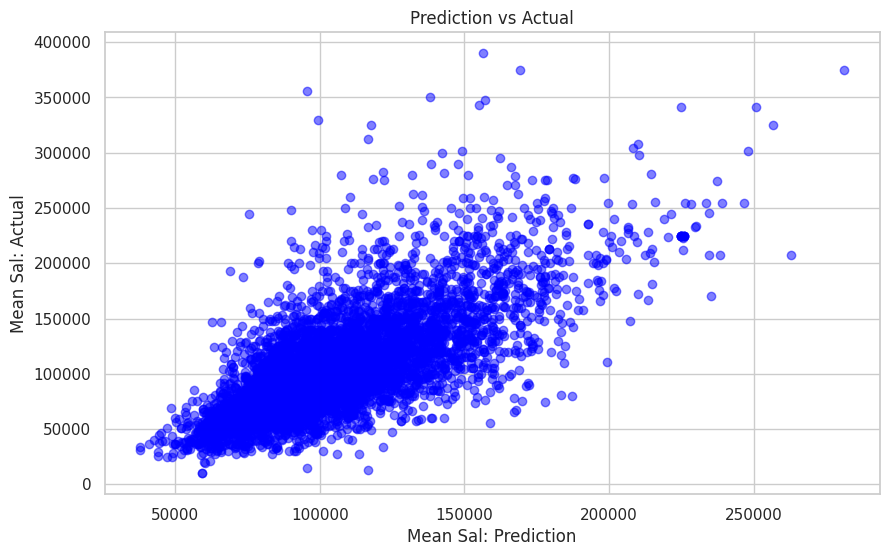

In [ ]:
#Plots a scatter graph to visualize the relationship between model predictions and actual mean salaries fpr Random Forest Model

#Extract prediction and Mean_Salary columns from tuned_random_forest_predictions

predictions = tuned_random_forest_predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
mean_salaries = tuned_random_forest_predictions.select("Mean_Salary").rdd.flatMap(lambda x: x).collect()

# Plot the graph
plt.figure(figsize=(10, 6))
plt.scatter(predictions, mean_salaries, alpha=0.5, c='blue')
plt.title("Prediction vs Actual")
plt.xlabel("Mean Sal: Prediction")
plt.ylabel("Mean Sal: Actual")
plt.show()

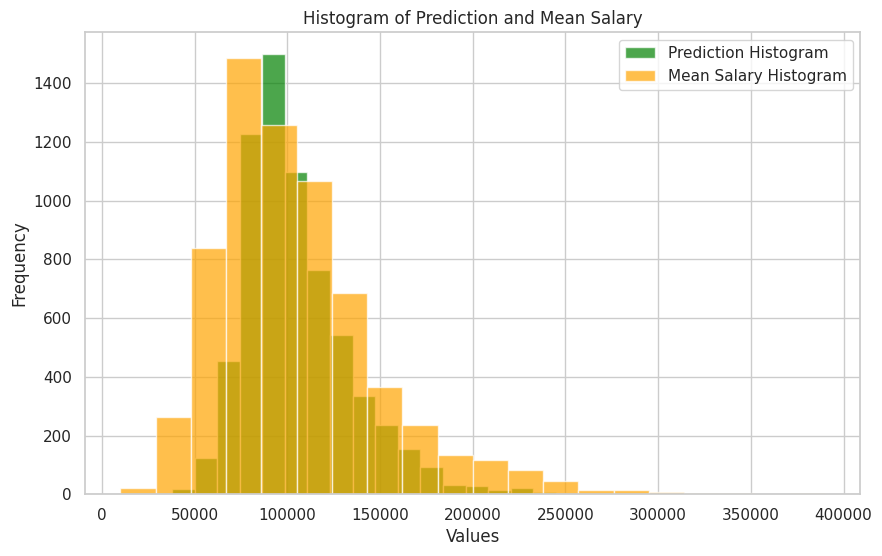

In [ ]:
# Histogram plot
plt.figure(figsize=(10, 6))
plt.hist(predictions, bins=20, alpha=0.7, color='green', label='Prediction Histogram')
plt.hist(mean_salaries, bins=20, alpha=0.7, color='orange', label='Mean Salary Histogram')
plt.title("Histogram of Prediction and Mean Salary")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#On Comparing the performance metrics of different regression models (Linear Regression, RandomForest, and DecisionTree)
##**Linear Regression Metrics:** The Linear Regression model has the highest MSE and RMSE, indicating a less accurate fit to the data compared to the other models.

##**RandomForest Metrics:** The RandomForest model performs better, as indicated by lower MSE, MAE, and RMSE values, and a higher R Squared.

##**DecisionTree Metrics:** The DecisionTree model has moderate performance, with R Squared indicating the proportion of variance in the dependent variable that is predictable.


##In conclusion, **RandomForest model** seems to be the most effective based on the provided metrics.